#  Classical-quantum Neural Network for binary classification

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, random, json, math
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re

import qiskit
from qiskit import transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import NLocal
from qiskit.circuit import QuantumCircuit, ClassicalRegister, ParameterVector
from qiskit.transpiler.passes import RemoveBarriers
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

## Data loading

In [ ]:
num_classes = 2
trapart = 0.8
val_part = 0.5 # from 1 - train_part

# hyper parameters
train_flag = False
epochs=30
initial_lr = 0.00025
w_decay = 0.0001
q_reps = 3

In [3]:
dataset_path = 'Dataset/'
dataset_name = 'task-3-dataset-15.csv'
df = pd.read_csv(dataset_path+dataset_name)
text = list(df['отзывы'])

In [4]:
lemmatize = nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('russian'))
new_text = []
for i in df['отзывы']:
    text_ = re.sub("[^a-zA-Zа-яА-Я1-9]"," ",i)
    text_ = nltk.word_tokenize(text_, language='russian')
    text_ = [word for word in text_ if word not in stop_words]
    text_ = [lemmatize.lemmatize(word) for word in text_]
    text_ = " ".join(text_)
    new_text.append(text_)

In [5]:
count = CountVectorizer(stop_words="english")
matrix = count.fit_transform(new_text).toarray()
max_len = len(matrix[0])
print(max_len)

1161


In [6]:
d = {'text_vec': matrix.tolist(), 'val': [1 if x=='+' else 0 for x in df['разметка']]}
df2 = pd.DataFrame(data=d)

df_train = df2[:int(len(df2)*0.8)]
df_test = df2.drop(df_train.index)
df_val = df_test[:int(len(df_test)*0.5)]
df_test = df_test.drop(df_val.index)

## The Network

In [7]:
### QUANTUM CLASS ###

# rotation block:
rot = QuantumCircuit(1)
params = ParameterVector('r', 1)
rot.ry(params[0], 0)

# entanglement block:
ent = QuantumCircuit(2)
ent.cx(0, 1)

class InitialStateQC:
    def __init__(self, n_qubits):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        params = ParameterVector('φ', n_qubits)
        
        for i in range(n_qubits):
            self._circuit.ry(params[i], i)


class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, input_circ = None, shots = 1024, reps = 2, measure = True):
        if(n_qubits == 1):
            qc_nlocal = NLocal(num_qubits=1, rotation_blocks=rot, entanglement='linear',
                skip_final_rotation_layer=True, insert_barriers=True, reps=reps, initial_state=input_circ)#
        else:
            qc_nlocal = NLocal(num_qubits=n_qubits, rotation_blocks=rot,
                entanglement_blocks=ent, entanglement='linear',
                skip_final_rotation_layer=True, insert_barriers=True, reps=reps, initial_state=input_circ)

        qc_nlocal = qc_nlocal.decompose()
        qc_nlocal = RemoveBarriers()(qc_nlocal)
        if(measure):
            out_size = int(math.log(n_qubits, 2))
            qc_nlocal.add_register(ClassicalRegister(out_size))
            for i in range(out_size - 1, -1, -1) :
                qc_nlocal.measure(n_qubits - i - 1, i)
        self._circuit = qc_nlocal

        self.backend = backend
        self.shots = shots
        self.num_qubit = n_qubits
    
    def run(self, param, backend = None, shots = 0):
        if (backend == None):
            backend = self.backend
        if (shots == 0):
            shots = self.shots


        t_qc = transpile(self._circuit.assign_parameters(param.cpu().data.numpy()), backend)
        job = backend.run(t_qc)
        result = job.result().get_counts()

        return result

In [8]:
def create_qnn(num_classes = 2):
    feature_map = InitialStateQC(num_classes)._circuit
    ansatz = MyQuantumCircuit(num_classes, AerSimulator(), measure = False, reps = q_reps)._circuit
    qc = QuantumCircuit(num_classes)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        output_shape=num_classes,
        input_gradients=True
    )
    return qnn

qnn = create_qnn(num_classes)

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


In [9]:
n_input_dim = 1160#!!!
n_hidden2 = 256
n_hidden3 = 64
num_q = num_classes
n_output =  1


class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.layer_2 = nn.Linear(n_input_dim, n_hidden2)
        self.layer_3 = nn.Linear(n_hidden2, n_hidden3)
        self.layer_qin = nn.Linear(n_hidden3, num_q)
        self.layer_qout = nn.Linear(2**num_q, n_output) 
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)

        self.qlayer = TorchConnector(qnn, initial_weights=torch.zeros(num_classes*q_reps))
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_2(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.relu(self.layer_qin(x))
        x = self.qlayer(x)
        x = self.sigmoid(self.layer_qout(x))
        
        return x
    
model = QNet()
model.load_state_dict(torch.load("param3_q.pth", weights_only=True))
model.eval()
for param in model.parameters():
    param.requires_grad = False
#print(model)
model = nn.Sequential(nn.Linear(max_len, n_input_dim), model)
print(model)

Sequential(
  (0): Linear(in_features=1161, out_features=1160, bias=True)
  (1): QNet(
    (layer_2): Linear(in_features=1160, out_features=256, bias=True)
    (layer_3): Linear(in_features=256, out_features=64, bias=True)
    (layer_qin): Linear(in_features=64, out_features=2, bias=True)
    (layer_qout): Linear(in_features=4, out_features=1, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.1, inplace=False)
    (qlayer): TorchConnector()
  )
)


c:\Users\Александр\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit_machine_learning\connectors\torch_connector.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=w_decay, amsgrad=True)
loss_fn = nn.BCELoss()

def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader)

    loss_, accuracy = 0, 0
    for row in dataloader.iterrows():
        pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
        loss = loss_fn(pred, torch.tensor([row[1]['val']]).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_ += loss.item()
        accuracy += (round(pred[0].tolist()) == row[1]['val'])
    
    loss_ /= size
    accuracy /= size
    print(loss_, accuracy)
    history['train_loss'].append(loss_)
    history['train_accuracy'].append(accuracy)
    return loss_, accuracy


def val_loop(dataloader, model, loss_fn, history):
    size = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for row in dataloader.iterrows():
            
            pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
            loss += loss_fn(pred, torch.tensor([row[1]['val']]).float())
            accuracy += (round(pred[0].tolist()) == row[1]['val'])

    loss /= size
    accuracy /= size
    print(loss.item(), accuracy)
    history['val_loss'].append(loss.item())
    history['val_accuracy'].append(accuracy)
    return loss, accuracy

def test_loop(dataloader, model, loss_fn, history, num_classes):
    size = len(dataloader)
    count = []

    for i in range(num_classes):
        count.append(0)

    with torch.no_grad():
        for row in dataloader.iterrows():
            
            pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
            count[row[1]['val']] += 1
            history['test_loss'][row[1]['val']][0] += (loss_fn(pred, torch.tensor([row[1]['val']]).float())).item()
            history['test_accuracy'][row[1]['val']][0] += round(pred[0].tolist()) == row[1]['val']

    loss, accuracy = 0, 0
    for i in range(num_classes):
        history['test_loss'][i][0] /= size
        loss += history['test_loss'][i][0]
        history['test_accuracy'][i][0] /= count[i]
        accuracy += history['test_accuracy'][i][0]

    loss /= num_classes
    accuracy /= num_classes
    
    return loss, accuracy

In [11]:
history = {
    'train_loss':[],
    'train_accuracy':[],
    'val_loss':[],
    'val_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for i in range(num_classes):
    history['test_loss'].append([0])
    history['test_accuracy'].append([0])


In [12]:
if(train_flag):
    for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
        train_loop(df_train, model, loss_fn, optimizer, history)
        val_loop(df_val, model, loss_fn, history)
    print("train loss and accuracy: ", history['train_loss'][-1], history['train_accuracy'][-1])
    print("val loss and accuracy: ", history['val_loss'][-1], history['val_accuracy'][-1])
else:
    model.load_state_dict(torch.load("param3_q_15.pth", weights_only=True))
    model.eval()

00:06 Elapsed |   3% done |▎         | 1/30 [03:02 remaining |  6.28s/epoch]

0.6778713420033455 0.6294117647058823
0.5025015473365784 0.7619047619047619


00:12 Elapsed |   7% done |▋         | 2/30 [02:52 remaining |  6.17s/epoch]

0.5017970788128235 0.7941176470588235
0.5555802583694458 0.7142857142857143


00:18 Elapsed |  10% done |█         | 3/30 [02:47 remaining |  6.19s/epoch]

0.4748500563642558 0.8058823529411765
0.581709623336792 0.7142857142857143


00:24 Elapsed |  13% done |█▎        | 4/30 [02:41 remaining |  6.20s/epoch]

0.4465258992770139 0.8235294117647058
0.5753632187843323 0.7142857142857143


00:31 Elapsed |  17% done |█▋        | 5/30 [02:36 remaining |  6.26s/epoch]

0.4371184492812437 0.8352941176470589
0.47994622588157654 0.7619047619047619


00:37 Elapsed |  20% done |██        | 6/30 [02:34 remaining |  6.43s/epoch]

0.3995024566264713 0.8705882352941177
0.5199683308601379 0.7619047619047619


00:44 Elapsed |  23% done |██▎       | 7/30 [02:30 remaining |  6.55s/epoch]

0.38227284559432195 0.8764705882352941
0.6117760539054871 0.7142857142857143


00:51 Elapsed |  27% done |██▋       | 8/30 [02:24 remaining |  6.58s/epoch]

0.33755016510977465 0.9176470588235294
0.5712182521820068 0.7142857142857143


00:58 Elapsed |  30% done |███       | 9/30 [02:19 remaining |  6.63s/epoch]

0.3482724649064681 0.8941176470588236
0.5383179783821106 0.7619047619047619


01:04 Elapsed |  33% done |███▎      | 10/30 [02:13 remaining |  6.68s/epoch]

0.33766044755192365 0.9058823529411765
0.5141386985778809 0.7619047619047619


01:11 Elapsed |  37% done |███▋      | 11/30 [02:07 remaining |  6.73s/epoch]

0.3023615595172433 0.9470588235294117
0.435570627450943 0.8095238095238095


01:18 Elapsed |  40% done |████      | 12/30 [02:01 remaining |  6.76s/epoch]

0.31787670044338 0.9235294117647059
0.4576561450958252 0.8095238095238095


01:25 Elapsed |  43% done |████▎     | 13/30 [01:55 remaining |  6.82s/epoch]

0.3027753233909607 0.9294117647058824
0.40622401237487793 0.8571428571428571


01:32 Elapsed |  47% done |████▋     | 14/30 [01:50 remaining |  6.89s/epoch]

0.2763479756958344 0.9470588235294117
0.3840234875679016 0.8571428571428571


01:39 Elapsed |  50% done |█████     | 15/30 [01:43 remaining |  6.93s/epoch]

0.27872603342813607 0.9470588235294117
0.42067381739616394 0.8571428571428571


01:46 Elapsed |  53% done |█████▎    | 16/30 [01:37 remaining |  6.95s/epoch]

0.2718465926016078 0.9529411764705882
0.44909703731536865 0.8095238095238095


01:53 Elapsed |  57% done |█████▋    | 17/30 [01:29 remaining |  6.91s/epoch]

0.2803183401332182 0.9470588235294117
0.43971574306488037 0.8571428571428571


02:00 Elapsed |  60% done |██████    | 18/30 [01:23 remaining |  6.96s/epoch]

0.28757144545807556 0.9411764705882353
0.4018402099609375 0.8571428571428571


02:07 Elapsed |  63% done |██████▎   | 19/30 [01:16 remaining |  6.97s/epoch]

0.27466343080296235 0.9470588235294117
0.367838054895401 0.9047619047619048


02:14 Elapsed |  67% done |██████▋   | 20/30 [01:09 remaining |  6.97s/epoch]

0.2764280043104116 0.9529411764705882
0.46868187189102173 0.8095238095238095


02:21 Elapsed |  70% done |███████   | 21/30 [01:02 remaining |  6.98s/epoch]

0.27170258620206045 0.9529411764705882
0.44689619541168213 0.8571428571428571


02:28 Elapsed |  73% done |███████▎  | 22/30 [00:55 remaining |  6.98s/epoch]

0.2691491419778151 0.9529411764705882
0.4518860876560211 0.8571428571428571


02:35 Elapsed |  77% done |███████▋  | 23/30 [00:48 remaining |  7.00s/epoch]

0.25718366126803793 0.9647058823529412
0.4608364999294281 0.8571428571428571


02:42 Elapsed |  80% done |████████  | 24/30 [00:42 remaining |  7.02s/epoch]

0.2556683543850394 0.9647058823529412
0.47944292426109314 0.8095238095238095


02:49 Elapsed |  83% done |████████▎ | 25/30 [00:35 remaining |  7.01s/epoch]

0.249927097734283 0.9705882352941176
0.4697447717189789 0.8095238095238095


02:56 Elapsed |  87% done |████████▋ | 26/30 [00:28 remaining |  7.04s/epoch]

0.25122976390754476 0.9705882352941176
0.4669288098812103 0.8571428571428571


03:03 Elapsed |  90% done |█████████ | 27/30 [00:20 remaining |  6.98s/epoch]

0.2622305195997743 0.9588235294117647
0.4612819254398346 0.8095238095238095


03:10 Elapsed |  93% done |█████████▎| 28/30 [00:13 remaining |  6.97s/epoch]

0.26332688761108064 0.9588235294117647
0.4833888113498688 0.8095238095238095


03:17 Elapsed |  97% done |█████████▋| 29/30 [00:06 remaining |  6.98s/epoch]

0.2618507940979565 0.9588235294117647
0.49026238918304443 0.8095238095238095


03:24 Elapsed | 100% done |██████████| 30/30 [00:00 remaining |  6.81s/epoch]

0.2567354664206505 0.9647058823529412
0.45840543508529663 0.8095238095238095
train loss and accuracy:  0.2567354664206505 0.9647058823529412
val loss and accuracy:  0.45840543508529663 0.8095238095238095


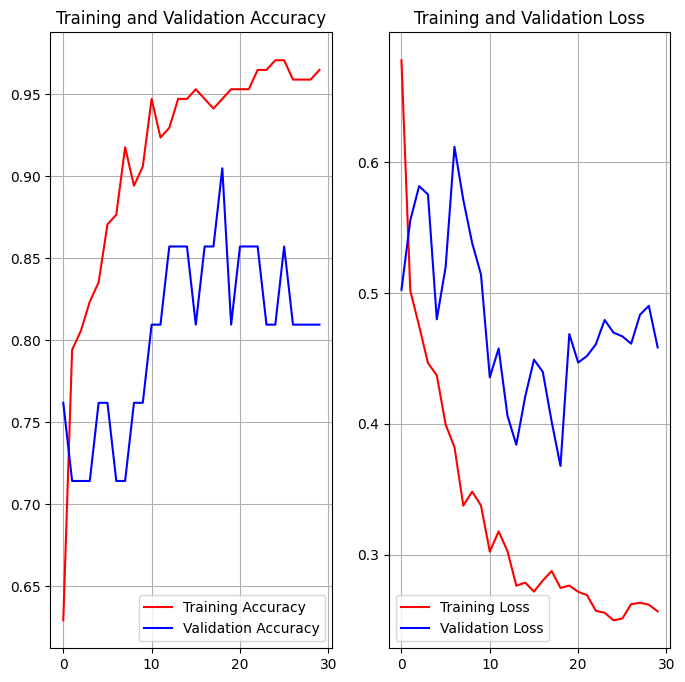

In [13]:
if(train_flag):
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='red')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='red')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='blue')
    plt.legend(loc='lower left')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()


In [14]:
tloss, tacc = test_loop(df_test, model, loss_fn, history, 2)
print("test loss and accuracy: ", tloss, tacc)
for i in range (num_classes):
    print("test loss and accuracy on target ", i, ": ", history['test_loss'][i][0], history['test_accuracy'][i][0])

test loss and accuracy:  0.0028403190424962136 0.8125
test loss and accuracy on target  0 :  0.0006514645012264901 1.0
test loss and accuracy on target  1 :  0.005029173583765937 0.625


In [15]:
if(train_flag):
    torch.save(model.state_dict(), 'param3_q_15.pth')